In [2]:
# !pip install -q transformers datasets scikit-learn
import os
os.environ["WANDB_DISABLED"] = "true"
# ✅ 載入套件
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
import torch

# ✅ 檢查 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ 載入 CSV 檔（請確保你上傳的是 training_data.csv）
df = pd.read_csv("/kaggle/input/sportsv-articles/training_data.csv") # 替換路徑
print(df.head())

# ✅ 轉為 Hugging Face Dataset 格式 & 切分訓練/驗證集
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# ✅ 載入中文 BERT tokenizer（可換成 chinese-roberta/macroBERT）
model_name = "bert-base-chinese"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

# ✅ Tokenize
def tokenize(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=512)

encoded_dataset = dataset.map(tokenize, batched=True)
encoded_dataset = encoded_dataset.rename_column("label", "labels")
encoded_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# ✅ 建立模型
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=7).to(device)

# ✅ 訓練參數
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

# ✅ 計算評估指標
label_names = ["賽事戰報", "球隊分析", "球員焦點", "交易與簽約", "教練與管理層", "選秀觀察", "歷史與專題"]

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    acc = accuracy_score(labels, preds)
    report = classification_report(
        labels,
        preds,
        target_names=label_names,
        labels=[0, 1, 2, 3, 4, 5, 6],
        digits=4,
        output_dict=True,
        zero_division=0  # 防止某類完全沒預測時出現除以零錯誤
    )
    return {
        "accuracy": acc,  # 這裡用手動計算的
        "f1_macro": report["macro avg"]["f1-score"],
        "precision_macro": report["macro avg"]["precision"],
        "recall_macro": report["macro avg"]["recall"],
    }

# ✅ 建立 Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# ✅ 開始訓練
trainer.train()

2025-05-31 09:14:00.949499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748682841.117316      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748682841.169146      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda
                                                text  label
0  回顧一下鵜鶘本季的表現，相對過去幾季是走得相對平穩，上季在季中經歷了雙星受傷因此吃了一波10...      1
1  層巒疊嶂，巍然屹立。主要討論有興趣的議題或球員，偶爾跟風評論時事話題 曾經有一段時期，只要彈...      2
2  「我想打籃球，想上場比賽。」 2024年四月，渡邊雄太在個人社群的直播中，宣布自己放棄新球季...      2
3  NBA洛杉磯湖人隊於今年的季後賽戰場失利，首輪就以1勝4敗遭到2022-2023年賽季奪下總...      4
4  法國勢力在NBA一直是一支中流砥柱，雖然早年一直被西班牙的Gasol兄弟壓制，但是從2010...      5


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_19/410476242.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,1.531200,1.124125,0.540000,0.245645,0.232228,0.277702
2,1.127500,1.011600,0.690000,0.374148,0.456172,0.371958
3,0.888700,0.844407,0.730000,0.405908,0.444146,0.405915
4,0.702800,0.734878,0.790000,0.459052,0.463530,0.462717


TrainOutput(global_step=200, training_loss=1.0625539588928223, metrics={'train_runtime': 133.6586, 'train_samples_per_second': 11.971, 'train_steps_per_second': 1.496, 'total_flos': 420996587520000.0, 'train_loss': 1.0625539588928223, 'epoch': 4.0})

📄 分類報表 classification report：

              precision    recall  f1-score   support

        賽事戰報     0.8929    0.9259    0.9091        27
        球隊分析     0.8519    0.8214    0.8364        28
        球員焦點     0.6667    0.8667    0.7536        30
       交易與簽約     0.8333    0.6250    0.7143         8
      教練與管理層     0.0000    0.0000    0.0000         2
        選秀觀察     0.0000    0.0000    0.0000         0
       歷史與專題     0.0000    0.0000    0.0000         5

   micro avg     0.7900    0.7900    0.7900       100
   macro avg     0.4635    0.4627    0.4591       100
weighted avg     0.7463    0.7900    0.7629       100



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

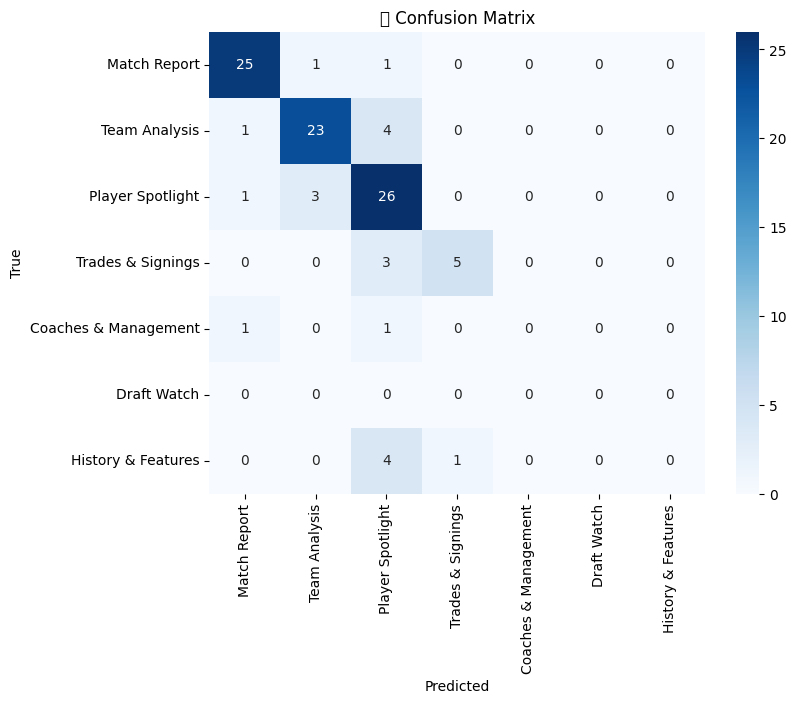

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
# 驗證集輸入
eval_dataset = encoded_dataset["test"]
predictions = trainer.predict(eval_dataset)

# 預測標籤與真實標籤
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# 列印完整報表
print("📄 分類報表 classification report：\n")
print(classification_report(
labels,
preds,
target_names=label_names,
labels=[0, 1, 2, 3, 4, 5, 6],
digits=4
))

# 混淆矩陣
cm = confusion_matrix(labels, preds, labels=[0, 1, 2, 3, 4, 5, 6])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Match Report", "Team Analysis", "Player Spotlight", "Trades & Signings", "Coaches & Management", "Draft Watch", "History & Features"], yticklabels=["Match Report", "Team Analysis", "Player Spotlight", "Trades & Signings", "Coaches & Management", "Draft Watch", "History & Features"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("🔍 Confusion Matrix")
plt.show()

In [4]:
# ✅ 儲存模型與 tokenizer
model.save_pretrained("./basketball-bert")
tokenizer.save_pretrained("./basketball-bert")

# ✅ 壓縮模型以供下載
!zip -r basketball-bert.zip basketball-bert

  adding: basketball-bert/ (stored 0%)
  adding: basketball-bert/tokenizer.json (deflated 75%)
  adding: basketball-bert/special_tokens_map.json (deflated 42%)
  adding: basketball-bert/config.json (deflated 58%)
  adding: basketball-bert/vocab.txt (deflated 48%)
  adding: basketball-bert/tokenizer_config.json (deflated 75%)
  adding: basketball-bert/model.safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 7%)
